In [4]:
import os
import arviz as az
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.tsa.deterministic import DeterministicProcess
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm 
# import tqdm as notebook_tqdm

import utils.globalsettings as gs

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 5] # 12, 7
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
df_groups = pd.read_csv(os.path.join(gs.the_folders.DIR_DATA_CLEAN, "ES_groups.csv"), sep = ";", parse_dates=["Date"], index_col=['Date'])

# Melt df_groups to long format
df_groups_long = df_groups.melt(ignore_index=False, var_name="group", value_name="value")

# Split 'group' column into 'group' (^.*-.*-) and 'variable' (the rest until the end)
df_groups_long[["group", "variable"]] = df_groups_long["group"].str.extract(r"^(.*-.*-[^_]*)_(.*)$")
df_groups_long.reset_index(inplace=True, drop=True)

# Create 'group_idx' column factorizing 'group'
df_groups_long["group_idx"] = pd.factorize(df_groups_long["group"])[0]

# Extract unique combinations of group and group_idx
group_idx = df_groups_long[["group", "group_idx"]].drop_duplicates().sort_values("group_idx").reset_index(drop = True)

group_idx


,group,group_idx
0,booking-luxury-b2b,0
1,booking-luxury-b2c,1
2,booking-rest-b2b,2
3,booking-rest-b2c,3
4,dir_web-luxury-b2b,4
5,dir_web-luxury-b2c,5
6,dir_web-rest-b2b,6
7,dir_web-rest-b2c,7
8,resto_otas-luxury-b2b,8
9,resto_otas-luxury-b2c,9


In [218]:
df = pd.read_csv(os.path.join(gs.the_folders.DIR_DATA_CLEAN, "BASE0_ES.csv"), sep = ";", parse_dates=["Date"])

df['group'] = df['group'] - 1

# rename column 'group' as 'group_idx'
df = df.rename(columns={"group": "group_idx"})

# Join df and group_idx
df = df.join(group_idx.set_index("group_idx"), on = "group_idx")

# Suponiendo df es tu DataFrame y ya tiene las columnas 'idx_group' y 'group'
# Añadir variables de tendencia y estacionalidad Fourier
dp = DeterministicProcess(
    index=df['Date'].unique(),
    constant=True,  # intercepto
    order=1,        # tendencia lineal
    seasonal=False,  # efectos estacionales
    fourier = 2,
    period=365.25/7       # asumiendo datos semanales
)
df_fourier = dp.in_sample()

# Unir las nuevas variables de Fourier a tu DataFrame original
df = df.join(df_fourier, on = ['Date']).set_index(['Date'], drop = True)

In [219]:
data = np.random.rand(4, 3)

locs = ["IA", "IL", "IN"]

times = pd.date_range("2000-01-01", periods=4)

xr.DataArray(
    data,
    coords={
        "time": times,
        "space": locs,
        "const": 42,
        "ranking": ("space", [1, 2, 3]),
    },
    dims=["time", "space"],
)

<xarray.DataArray (time: 4, space: 3)>
array([[0.43269282, 0.2415384 , 0.53028467],
       [0.83573755, 0.19800229, 0.39084413],
       [0.49221876, 0.97184866, 0.23269277],
       [0.63453245, 0.31591792, 0.13325439]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'
    const    int32 42
    ranking  (space) int32 1 2 3

In [220]:
lst_np_arrays = []
probe = df.drop(['group', 'group_idx'], axis = 1)
for idx_g in df['group_idx'].unique():
    lst_np_arrays.append(probe.loc[df['group_idx'] == idx_g, :].values)

np_array = np.stack(lst_np_arrays, axis = 2)

# Transformar el DataFrame a un xr.DataArray
data_array = xr.DataArray(
    np_array,
    coords = {
        'Date':      df.index.unique(), 
        'variable':  probe.columns,
        'group_idx': df['group_idx'].unique(), 
        'group':     ('group_idx', df['group'].unique())
        },
    dims = ['Date', 'variable', 'group_idx'],
    )

data_array 


<xarray.DataArray (Date: 109, variable: 46, group_idx: 12)>
array([[[0.00000000e+00, 4.40000000e+01, 1.11111111e+01, ...,
         7.00000000e+00, 9.00000000e+01, 1.45960000e+03],
        [3.57081000e+05, 3.57081000e+05, 3.57081000e+05, ...,
         3.57081000e+05, 3.57081000e+05, 3.57081000e+05],
        [4.57000000e+03, 4.57000000e+03, 4.57000000e+03, ...,
         4.57000000e+03, 4.57000000e+03, 4.57000000e+03],
        ...,
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],

       [[0.00000000e+00, 4.20000000e+01, 9.25000000e+00, ...,
         1.30000000e+01, 1.29032258e+02, 1.48300000e+03],
        [3.57081000e+05, 3.57081000e+05, 3.57081000e+05, ...,
         3.57081000e+05, 3.57081000e+05, 3.57081000e+05],
        [3.25900000e+03, 3.25900000e+03, 3.25900000e+03, ...,
         3.25900000e+03, 3.25900000e+03, 3.25900000e+03],
...
        [9.49786070e-01, 9.49786070e-01, 9.49786070e-01, ...,
         9.49786070e-01, 9.49786070e-01, 9.49786070e-01],
        [5.94376157e-01, 5.94376157e-01, 5.94376157e-01, ...,
         5.94376157e-01, 5.94376157e-01, 5.94376157e-01],
        [8.04187158e-01, 8.04187158e-01, 8.04187158e-01, ...,
         8.04187158e-01, 8.04187158e-01, 8.04187158e-01]],

       [[0.00000000e+00, 6.90000000e+01, 6.93333333e+00, ...,
         1.20000000e+01, 1.18800000e+02, 2.06752222e+03],
        [5.23721000e+05, 5.23721000e+05, 5.23721000e+05, ...,
         5.23721000e+05, 5.23721000e+05, 5.23721000e+05],
        [1.78300000e+03, 1.78300000e+03, 1.78300000e+03, ...,
         1.78300000e+03, 1.78300000e+03, 1.78300000e+03],
        ...,
        [9.05320842e-01, 9.05320842e-01, 9.05320842e-01, ...,
         9.05320842e-01, 9.05320842e-01, 9.05320842e-01],
        [7.69030859e-01, 7.69030859e-01, 7.69030859e-01, ...,
         7.69030859e-01, 7.69030859e-01, 7.69030859e-01],
        [6.39211653e-01, 6.39211653e-01, 6.39211653e-01, ...,
         6.39211653e-01, 6.39211653e-01, 6.39211653e-01]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2021-11-01 2021-11-08 ... 2023-11-27
  * variable   (variable) object 'reservas' 'CRM_messages' ... 'cos(2,52.18)'
  * group_idx  (group_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11
    group      (group_idx) object 'booking-luxury-b2b' ... 'resto_otas-rest-b2c'

In [221]:
data_array['group'].sel(group_idx = 3).values.reshape((1))[0]

'booking-rest-b2c'

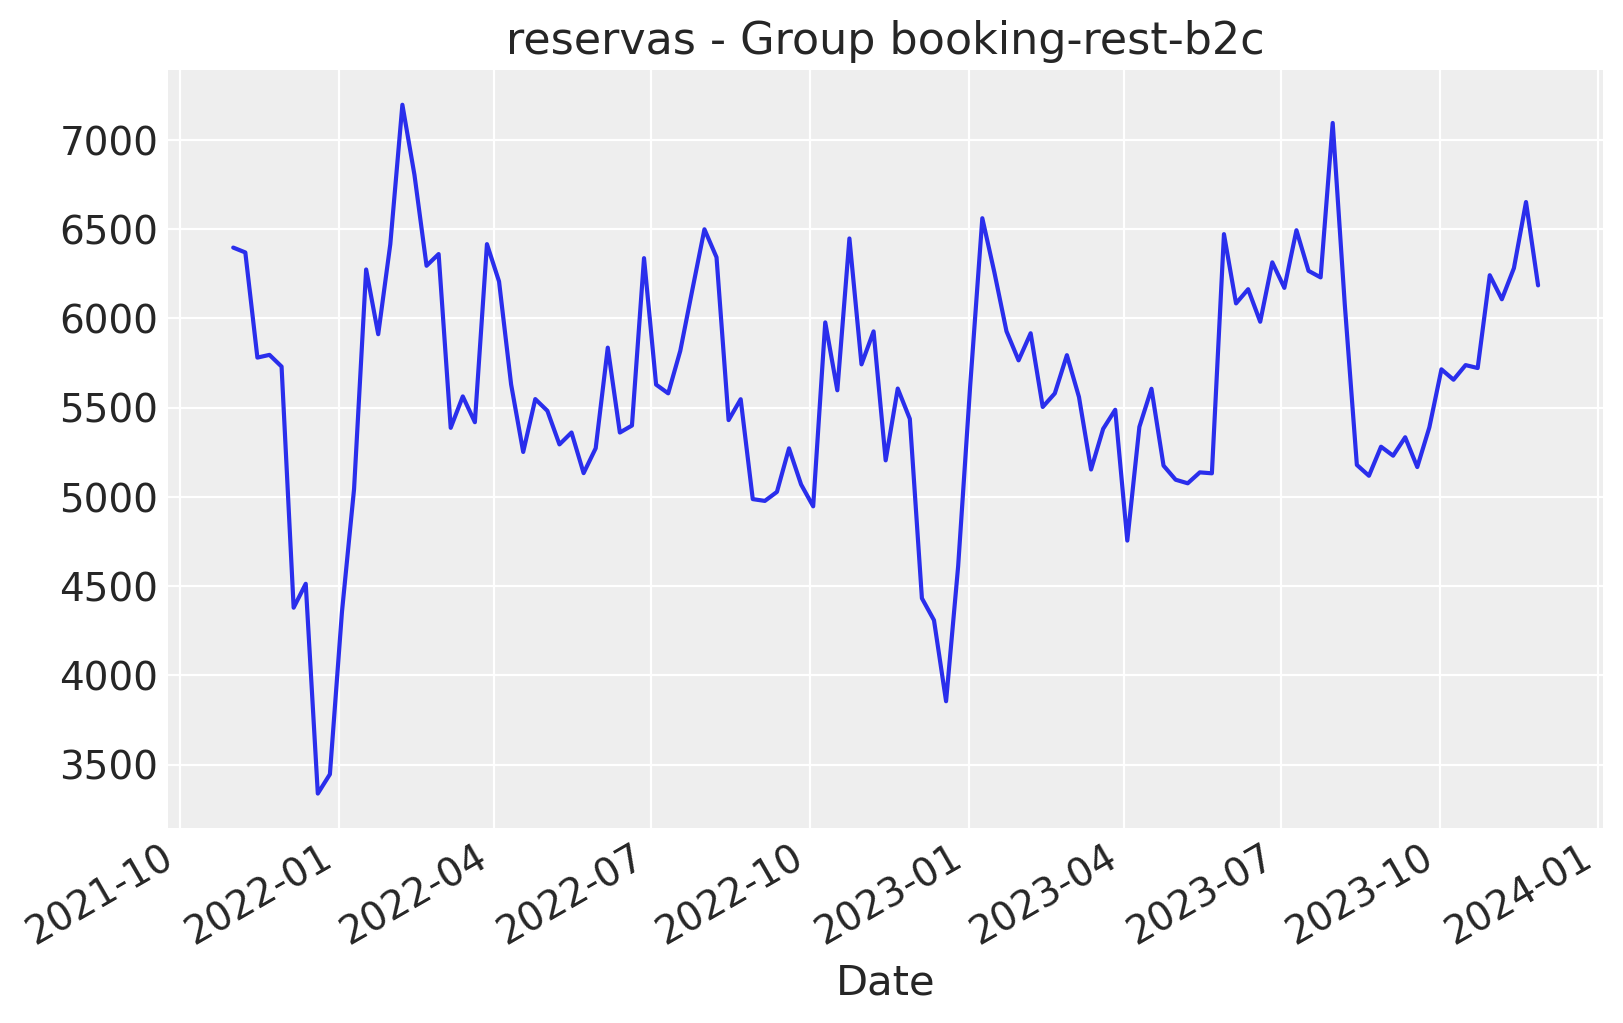

In [222]:
data_array.sel(variable = "reservas", group_idx = 3).plot()
plt.title(f"reservas - Group {data_array['group'].sel(group_idx = 3).values.reshape((1))[0]}");

<Axes: xlabel='Date'>

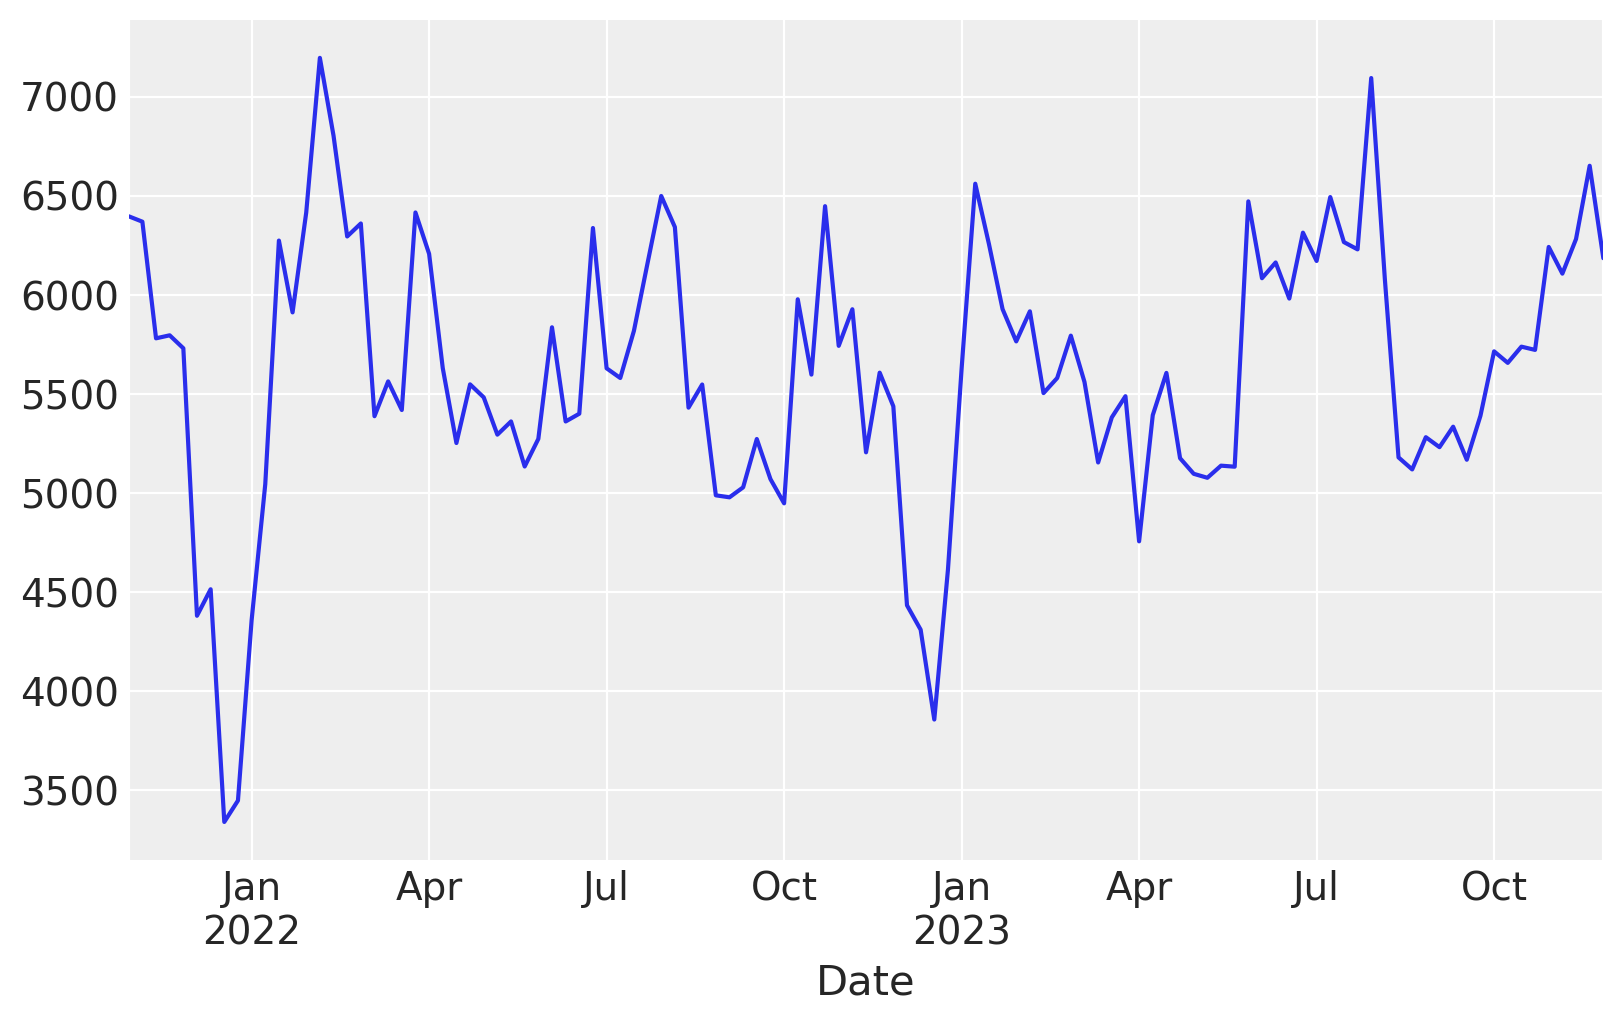

In [223]:
df.loc[df['group_idx'] == 3, 'reservas'].plot()

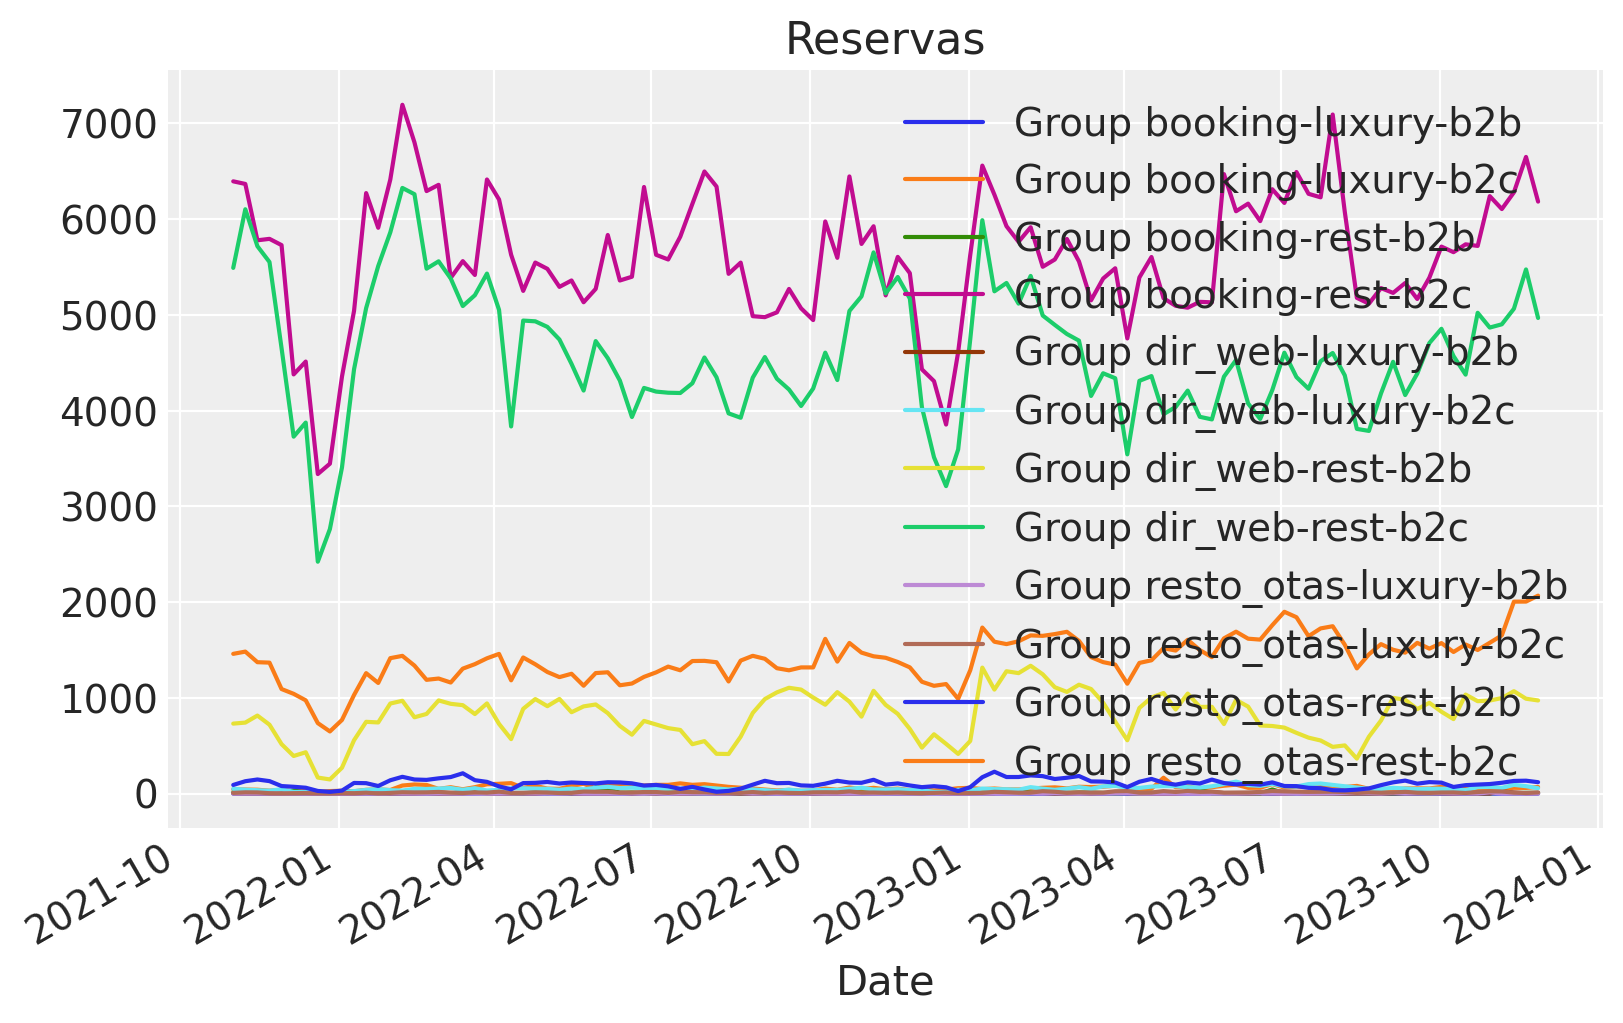

In [224]:
for g_idx in data_array['group_idx']:
    data_array.sel(variable = "reservas", group_idx = g_idx).plot(label = f"Group {data_array['group'].sel(group_idx = g_idx).values.reshape((1))[0]}")
plt.title("Reservas")
plt.legend()

In [225]:
data_array['variable']

<xarray.DataArray 'variable' (variable: 46)>
array(['reservas', 'CRM_messages', 'Destination_ads', 'Display_Segmentado',
       'Festivos', 'GRP_Competencia', 'Google_Hotel', 'Google_PMAX',
       'Google_Search_Brand', 'Google_Search_Hybrid', 'Google_Search_No_Brand',
       'Meta_branding', 'Meta_performance', 'Metabuscadores', 'OTA_Travel_ads',
       'Offline_competencia', 'Offline_propio', 'Prospecting', 'Retargeting',
       'Seatback_cabeceros', 'TikTok', 'Youtube', 'ari_metric', 'gri_index',
       'mpi_metric', 'nps_index', 'promocionblackfriday',
       'promociondiscovery_dollars', 'promociondoublenights',
       'promocionupto10-offseason', 'promocionupto10-season',
       'promocionupto15-offseason', 'promocionupto15-season',
       'promocionupto20-season', 'promocionupto25-season',
       'promocionupto30-season', 'promocionupto35-offseason',
       'promocionupto40-offseason', 'rgi_metric', 'relative_ari_metric',
       'const', 'trend', 'sin(1,52.18)', 'cos(1,52.18)', 'sin(2,52.18)',
       'cos(2,52.18)'], dtype=object)
Coordinates:
  * variable  (variable) object 'reservas' 'CRM_messages' ... 'cos(2,52.18)'

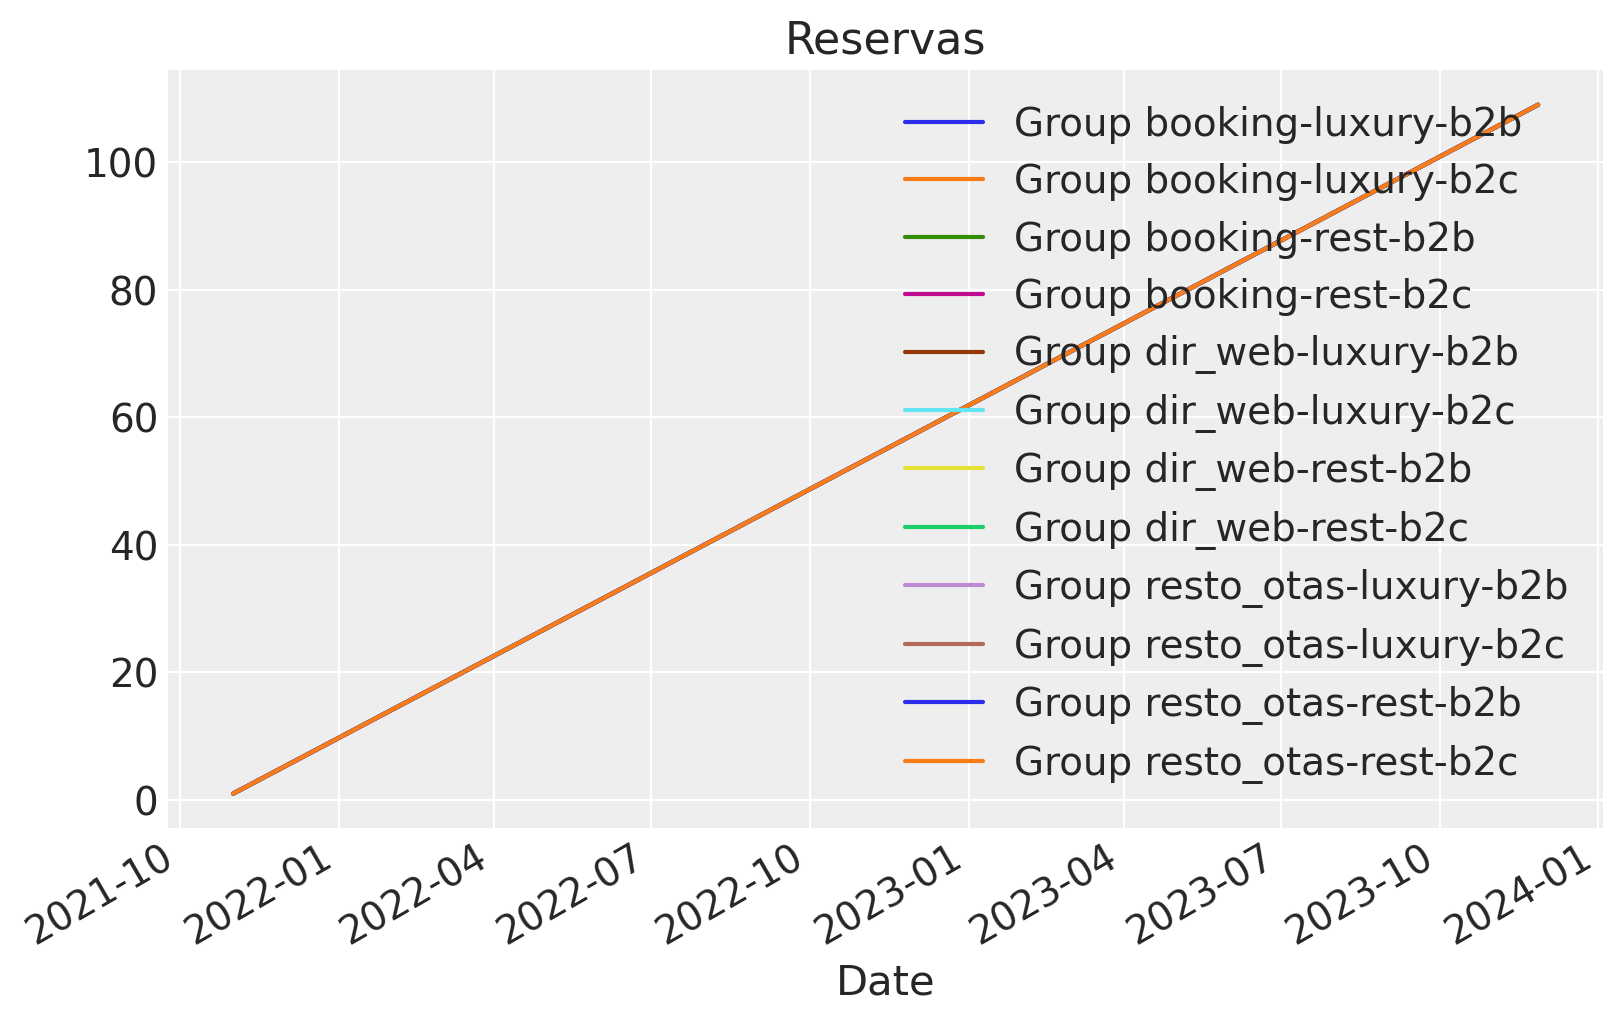

In [226]:
for g_idx in data_array['group_idx']:
    data_array.sel(variable = "trend", group_idx = g_idx).plot(label = f"Group {data_array['group'].sel(group_idx = g_idx).values.reshape((1))[0]}")
plt.title("Reservas")
plt.legend()

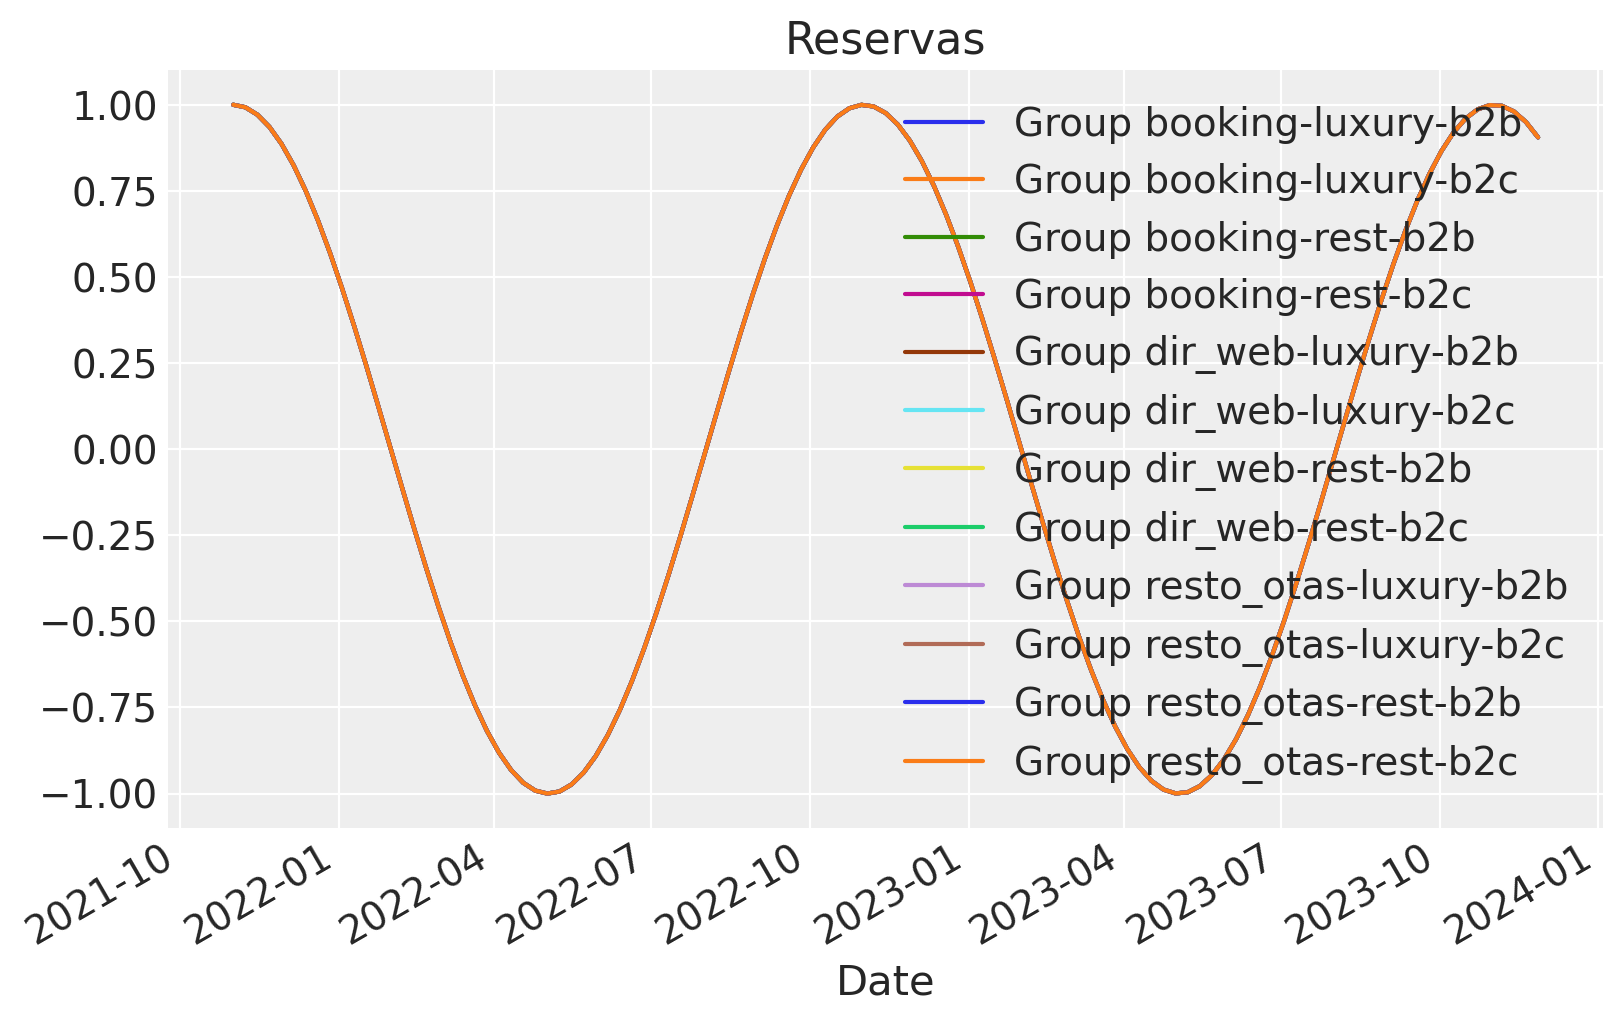

In [230]:
for g_idx in data_array['group_idx']:
    data_array.sel(variable = "cos(1,52.18)", group_idx = g_idx).plot(label = f"Group {data_array['group'].sel(group_idx = g_idx).values.reshape((1))[0]}")
plt.title("Reservas")
plt.legend()